# Import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
import optuna 
import os

In [481]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn. impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [21]:
import astropy
import astroquery
from astroquery.vizier import Vizier

In [171]:
from astroquery.sdss import SDSS
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

In [249]:
import time 
from concurrent.futures import ThreadPoolExecutor
import requests

In [313]:
from tqdm import tqdm
from scipy.interpolate import interp1d
import re

# DATA visualization

In [58]:
query= """ 
SELECT 
        plate, mjd, fiberid, subclass, class
FROM SpecObjAll
WHERE
        class = 'STAR' AND
        subclass LIKE 'WD'
"""

In [59]:
sdss_data= SDSS.query_sql(query)

In [60]:
sdss_data.pprint()

plate  mjd  fiberid subclass class
----- ----- ------- -------- -----
  266 51602      22       WD  STAR
  266 51630      26       WD  STAR
  266 51602      29       WD  STAR
  266 51602      31       WD  STAR
  266 51630      31       WD  STAR
  266 51630      32       WD  STAR
  266 51602      34       WD  STAR
  266 51630      37       WD  STAR
  266 51602     314       WD  STAR
  266 51630     314       WD  STAR
  ...   ...     ...      ...   ...
 3245 54894     358       WD  STAR
 3247 54888     162       WD  STAR
 3247 54888     637       WD  STAR
 3248 54880      57       WD  STAR
 3248 54880      84       WD  STAR
 3300 54914     339       WD  STAR
 3300 54914     399       WD  STAR
 3300 54914     499       WD  STAR
 3303 54950      25       WD  STAR
 3478 55008     228       WD  STAR
Length = 15799 rows


In [57]:

if sdss_data is not None:
    sdss_data.pprint(max_width=100)
else:
    print("⚠️ No results returned — check your query or widen your filters.")

plate  mjd  fiberid subclass class
----- ----- ------- -------- -----
  383 51818     216       WD  STAR
  384 51821     151       WD  STAR
  386 51788     110       WD  STAR
  386 51788     297       WD  STAR
  387 51791       5       WD  STAR
  388 51793       1       WD  STAR
  388 51793       9       WD  STAR
  388 51793      74       WD  STAR
  391 51782     520       WD  STAR
  647 52553     371       WD  STAR
  ...   ...     ...      ...   ...
 2312 53709     392       WD  STAR
 2327 53710       2       WD  STAR
 2327 53710     321       WD  STAR
 2327 53710     325       WD  STAR
 2628 54326      27       WD  STAR
 2628 54326     340       WD  STAR
 2628 54326     345       WD  STAR
 2630 54327       9       WD  STAR
 2630 54327      78       WD  STAR
 2630 54327     633       WD  STAR
Length = 283 rows


# DATA Cleaning


In [61]:
Vizier.ROW_LIMIT= -1

In [62]:
catalog_list= Vizier.find_catalogs('J/MNRAS/486/2169')
print(catalog_list)

OrderedDict({'J/MNRAS/486/2169': </>})


In [67]:
sdss_wd_list = Vizier.get_catalogs('J/MNRAS/486/2169')
sdss_wd_list = sdss_wd_list[0]

In [68]:
sdss_wd_list

P-M-F,SDSSJ,SNg,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,E(B-V),PM,GLON,GLAT,Type,Sp,_RA,_DE
,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mas / yr,deg,deg,,,deg,deg
str16,str19,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str29,str2,float64,float64
0266-51602-0314,094107.47-001949.70,12,19.369,0.023,18.965,0.014,19.063,0.012,19.231,0.018,19.356,0.058,0.053,20.9,235.9,36.7,DA,Sp,145.28112,-0.33047
0266-51630-0015,094739.30-003840.13,20,19.405,0.029,18.104,0.018,18.097,0.022,18.128,0.029,18.216,0.034,0.078,17.4,237.4,37.9,sdA,Sp,146.91375,-0.64447
0266-51630-0026,094901.28-001909.61,40,16.951,0.010,16.511,0.014,16.642,0.010,16.813,0.013,17.012,0.019,0.066,109.9,237.3,38.3,DA,Sp,147.25533,-0.31933
0266-51630-0031,094804.30-000738.16,15,18.688,0.023,18.278,0.017,18.342,0.011,18.470,0.023,18.611,0.035,0.088,48.2,236.9,38.2,DA,Sp,147.01792,-0.12725
0266-51630-0037,094917.06-000023.67,11,19.271,0.024,18.796,0.018,18.934,0.016,19.108,0.021,19.294,0.055,0.067,47.4,237.0,38.6,DA,Sp,147.32108,-0.00656
0266-51630-0233,094218.23-002519.65,53,16.965,0.012,15.676,0.015,15.700,0.015,15.736,0.016,15.837,0.016,0.050,13.8,236.2,36.9,sdA/F,Sp,145.57596,-0.42211
0266-51630-0570,094640.35+011319.86,32,17.320,0.020,17.196,0.024,17.549,0.019,17.814,0.022,18.060,0.029,0.127,32.8,235.3,38.7,DA,Sp,146.66812,1.22217
0266-51630-0629,094844.84+003516.63,26,18.090,0.016,17.649,0.011,17.932,0.013,18.085,0.014,18.305,0.034,0.068,98.9,236.3,38.8,DA,Sp,147.18683,0.58794


In [69]:
sdss_wd_list= sdss_wd_list.to_pandas()

In [73]:
sdss_wd_list.isna().sum()

P-M-F     0
SDSSJ     0
SNg       0
umag      8
e_umag    8
gmag      8
e_gmag    8
rmag      8
e_rmag    8
imag      8
e_imag    8
zmag      8
e_zmag    8
E(B-V)    8
PM        8
GLON      8
GLAT      8
Type      0
Sp        0
_RA       0
_DE       0
dtype: int64

In [90]:
keep_types = ['DA', 'DB', 'DC', 'DQ', 'DZ']

sdss_wd_clean = sdss_wd_list[sdss_wd_list['Type'].isin(keep_types)]

#sdss_wd_clean  = sdss_wd_clean [~sdss_wd_clean ['Type'].str.contains(':', na=False)]

In [127]:
x1 = sdss_wd_clean.loc[:,['umag','gmag', 'rmag', 'imag', 'zmag']]

In [128]:
y1= sdss_wd_clean['Type']

In [129]:
y1

0        DA
2        DA
3        DA
4        DA
6        DA
         ..
37390    DZ
37391    DC
37393    DA
37394    DA
37395    DA
Name: Type, Length: 17283, dtype: object

In [94]:
sdss_wd_clean['Type'].unique()

array(['DA', 'DZ', 'DC', 'DQ', 'DB'], dtype=object)

In [130]:
x_train, x_valid, y_train, y_valid= train_test_split(x1,y1,train_size=0.8, random_state=42)

In [111]:
x1

0        DA
2        DA
3        DA
4        DA
6        DA
         ..
37390    DZ
37391    DC
37393    DA
37394    DA
37395    DA
Name: Type, Length: 17283, dtype: object

# Preprocessing

In [131]:
num_features= ['umag','gmag', 'rmag', 'imag', 'zmag']


In [132]:
numeric_transformer= Pipeline(steps= [
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])
catagorical_transformer= Pipeline( steps= [
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown= 'ignore'))
    ])

In [138]:
preprocessor = ColumnTransformer(transformers= [
    ('num', numeric_transformer, num_features)
    #('cat', catagorical_transformer, cat_features)
])


In [134]:
pipeline_1= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cb.CatBoostClassifier(verbose=0))
])


In [164]:
def sdss_pho_objective(trial):
    param_sdss= {
    "learning_rate": trial.suggest_float("classifier__learning_rate", 0.01, 0.3, log=True),
    "depth": trial.suggest_int("classifier__depth", 4, 10),
    "l2_leaf_reg": trial.suggest_float("classifier__l2_leaf_reg", 1, 10),
    "iterations": trial.suggest_int("classifier__iterations", 100, 1000),
    }
    model= cb.CatBoostClassifier(**param_sdss, verbose=0)

    pipeline_1= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
    ])
    pipeline_1.fit(x_train, y_train)
    preds= pipeline_1.predict(x_valid)
    accuracy= accuracy_score(y_valid, preds)
    return 1.0 - accuracy

    

In [165]:
study_photo= optuna.create_study()
study_photo.optimize(sdss_pho_objective,n_trials=30)
print("Best Hyperparameters:", study_photo.best_params)

[I 2025-07-04 11:13:52,221] A new study created in memory with name: no-name-1097e24e-10cc-4431-a673-2ec8b49106fa
[I 2025-07-04 11:13:54,867] Trial 0 finished with value: 0.14723748915244428 and parameters: {'classifier__learning_rate': 0.14287106012051443, 'classifier__depth': 5, 'classifier__l2_leaf_reg': 3.545259346908769, 'classifier__iterations': 988}. Best is trial 0 with value: 0.14723748915244428.
[I 2025-07-04 11:13:57,046] Trial 1 finished with value: 0.16951113682383567 and parameters: {'classifier__learning_rate': 0.021448510670204157, 'classifier__depth': 4, 'classifier__l2_leaf_reg': 1.781206326717511, 'classifier__iterations': 918}. Best is trial 0 with value: 0.14723748915244428.
[I 2025-07-04 11:13:59,554] Trial 2 finished with value: 0.15128724327451548 and parameters: {'classifier__learning_rate': 0.22065386718321356, 'classifier__depth': 6, 'classifier__l2_leaf_reg': 7.425763083842605, 'classifier__iterations': 523}. Best is trial 0 with value: 0.14723748915244428.


Best Hyperparameters: {'classifier__learning_rate': 0.18145501815616288, 'classifier__depth': 10, 'classifier__l2_leaf_reg': 9.252692860407663, 'classifier__iterations': 744}


In [166]:
study_photo.best_value

0.1388487127567255

In [167]:
best_params = study_photo.best_params
best_model = cb.CatBoostClassifier(
    learning_rate=best_params["classifier__learning_rate"],
    depth=best_params["classifier__depth"],
    l2_leaf_reg=best_params["classifier__l2_leaf_reg"],
    iterations=best_params["classifier__iterations"],
    verbose=0
)

final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", best_model)
])
final_pipe.fit(x_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x1778de0f0>)])

In [169]:
y_pred = final_pipe.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

          DA       0.87      0.99      0.93      2842
          DB       0.84      0.42      0.56       196
          DC       0.51      0.20      0.28       235
          DQ       0.54      0.18      0.27        74
          DZ       0.72      0.21      0.32       110

    accuracy                           0.86      3457
   macro avg       0.70      0.40      0.47      3457
weighted avg       0.84      0.86      0.83      3457



In [170]:
ra_list= sdss_wd_clean['_RA']
dec_list = sdss_wd_clean['_DE']


# Loop& Astroquery Download Spectrum(Slow)

In [238]:
def sdss_get_spectrum(ra_list, dec_list,radius_arcsec=2, save_dir = 'Spectra', max_objects=50):
    os.makedirs(save_dir, exist_ok= True) #Make Sure File exist
    downloaded=0
    for i, (ra, dec) in enumerate(zip(ra_list,dec_list)):
        if i >= max_objects:
            break

        filename = os.path.join(save_dir, f"spectrum_{i:04d}.fits")
        if os.path.exists(filename):
            print(f"{filename} already exists, skipping.") # Skip Existing files 
            continue
        
        position= SkyCoord(ra=ra, dec= dec, unit='deg')
        try:
            xid= SDSS.query_region(position, radius= radius_arcsec * u.arcsec, spectro= True) # Find object
            if xid is not None:
                sp= SDSS.get_spectra(matches=xid)

                if sp:
                    #filename = f"{save_dir}/spectrum_{i:04d}.fits"
                    sp[0].writeto(filename, overwrite=True)# Download Spectrum
                    print(f"Yes! Spectrum Found for {i}, RA{ra}, Dec{dec}'")
                    downloaded +=1
                    if downloaded %50 ==0:
                        print(f'{downloaded} spectra downloaded...')
                else: 
                    print(f'Spectrum Not Found for {i}, RA{ra}, Dec{dec}')
            else:
                print(f'No match found for {i}, RA{ra}, Dec{dec}')

        except Exception as e:
            print(f"Error on object {i}: {e}")

        time.sleep(0.5) # Prevent Burdun the Server


In [ ]:
sdss_get_spectrum(ra_list, dec_list,save_dir='Spectra', max_objects=10)

In [197]:
df_da = sdss_wd_clean[sdss_wd_clean["Type"] == "DA"].sample(n=1000)
df_db = sdss_wd_clean[sdss_wd_clean["Type"] == "DB"].sample(n=700)
df_dc = sdss_wd_clean[sdss_wd_clean["Type"] == "DC"].sample(n=700)
df_dz = sdss_wd_clean[sdss_wd_clean["Type"] == "DZ"].sample(n=450)
df_dq = sdss_wd_clean[sdss_wd_clean["Type"] == "DQ"].sample(n=400)
df_balanced = pd.concat([df_da, df_db, df_dc, df_dq, df_dz])# Balanced Dataset for ML

In [253]:
sdss_get_spectrum(ra_list=df_balanced['_RA'],dec_list=df_balanced['_DE'],save_dir='sdss_ml_data', max_objects=3500)

sdss_ml_data/spectrum_0000.fits already exists, skipping.
sdss_ml_data/spectrum_0001.fits already exists, skipping.
sdss_ml_data/spectrum_0002.fits already exists, skipping.
sdss_ml_data/spectrum_0003.fits already exists, skipping.
sdss_ml_data/spectrum_0004.fits already exists, skipping.
sdss_ml_data/spectrum_0005.fits already exists, skipping.
sdss_ml_data/spectrum_0006.fits already exists, skipping.
sdss_ml_data/spectrum_0007.fits already exists, skipping.
sdss_ml_data/spectrum_0008.fits already exists, skipping.
sdss_ml_data/spectrum_0009.fits already exists, skipping.
sdss_ml_data/spectrum_0010.fits already exists, skipping.
sdss_ml_data/spectrum_0011.fits already exists, skipping.
sdss_ml_data/spectrum_0012.fits already exists, skipping.
sdss_ml_data/spectrum_0013.fits already exists, skipping.
sdss_ml_data/spectrum_0014.fits already exists, skipping.
sdss_ml_data/spectrum_0015.fits already exists, skipping.
sdss_ml_data/spectrum_0016.fits already exists, skipping.
sdss_ml_data/s

Yes! Spectrum Found for 1697, RA234.06546, Dec57.81736'
Yes! Spectrum Found for 1698, RA255.75279, Dec36.54675'
Yes! Spectrum Found for 1699, RA127.64642, Dec56.74981'
Yes! Spectrum Found for 1700, RA223.68729, Dec5.67339'
Yes! Spectrum Found for 1701, RA192.30171, Dec11.94361'
Yes! Spectrum Found for 1702, RA136.16158, Dec0.14758'
Yes! Spectrum Found for 1703, RA196.52825, Dec59.43594'
Yes! Spectrum Found for 1704, RA161.69633, Dec1.99225'
Yes! Spectrum Found for 1705, RA257.36329, Dec21.21347'
Yes! Spectrum Found for 1706, RA334.79342, Dec0.84542'
Yes! Spectrum Found for 1707, RA182.00771, Dec-0.70514'
Yes! Spectrum Found for 1708, RA126.83637, Dec39.13517'
Yes! Spectrum Found for 1709, RA144.54067, Dec14.46936'
Yes! Spectrum Found for 1710, RA337.41933, Dec6.95211'
Yes! Spectrum Found for 1711, RA176.89733, Dec30.15578'
Yes! Spectrum Found for 1712, RA263.42883, Dec55.73861'
Yes! Spectrum Found for 1713, RA181.62183, Dec20.46625'
Yes! Spectrum Found for 1714, RA139.51175, Dec-2.0851

MC1THT  =-0.00000000000000E+00 / sp1 mech Temp_Hartmann_Top                      [astropy.io.fits.card]


Yes! Spectrum Found for 1733, RA127.20362, Dec31.52631'
Yes! Spectrum Found for 1734, RA212.93021, Dec22.11247'
Yes! Spectrum Found for 1735, RA149.75392, Dec55.03925'
Yes! Spectrum Found for 1736, RA44.37825, Dec-7.13394'
Yes! Spectrum Found for 1737, RA212.07042, Dec34.94183'
Yes! Spectrum Found for 1738, RA190.33575, Dec27.15578'
Yes! Spectrum Found for 1739, RA117.23129, Dec23.65242'
Yes! Spectrum Found for 1740, RA230.9515, Dec14.24814'
Yes! Spectrum Found for 1741, RA145.53954, Dec54.03264'


Yes! Spectrum Found for 1742, RA179.91346, Dec35.96467'
Yes! Spectrum Found for 1743, RA293.18512, Dec62.04817'
Yes! Spectrum Found for 1744, RA224.63637, Dec-1.21261'
Yes! Spectrum Found for 1745, RA181.72325, Dec8.59742'
Yes! Spectrum Found for 1746, RA18.35317, Dec25.96914'
Yes! Spectrum Found for 1747, RA211.91812, Dec20.16767'
Yes! Spectrum Found for 1748, RA124.113, Dec14.08144'
Yes! Spectrum Found for 1749, RA169.20275, Dec55.66139'
Yes! Spectrum Found for 1750, RA236.12204, Dec54.93067'
Yes! Spectrum Found for 1751, RA112.97246, Dec41.61356'
Yes! Spectrum Found for 1752, RA63.37921, Dec15.20769'
Yes! Spectrum Found for 1753, RA11.456, Dec23.14356'
Yes! Spectrum Found for 1754, RA233.85154, Dec21.03958'
Yes! Spectrum Found for 1755, RA25.52367, Dec23.77506'
Yes! Spectrum Found for 1756, RA144.84871, Dec26.14428'
Yes! Spectrum Found for 1757, RA113.813, Dec36.41244'
Yes! Spectrum Found for 1758, RA233.48833, Dec47.69178'
Yes! Spectrum Found for 1759, RA130.362, Dec39.44861'
Yes! 

Yes! Spectrum Found for 1819, RA114.50333, Dec43.43381'
Yes! Spectrum Found for 1820, RA238.68858, Dec13.45286'
Yes! Spectrum Found for 1821, RA178.34467, Dec12.24583'
Yes! Spectrum Found for 1822, RA17.40962, Dec34.90908'
Yes! Spectrum Found for 1823, RA160.47425, Dec14.26331'
Yes! Spectrum Found for 1824, RA11.90733, Dec19.56639'
Yes! Spectrum Found for 1825, RA210.85279, Dec45.55908'
Yes! Spectrum Found for 1826, RA254.00725, Dec46.81792'
Yes! Spectrum Found for 1827, RA225.94579, Dec29.9475'
Yes! Spectrum Found for 1828, RA230.2735, Dec7.81247'
Yes! Spectrum Found for 1829, RA244.20954, Dec16.19786'
Yes! Spectrum Found for 1830, RA117.82125, Dec43.80753'
Yes! Spectrum Found for 1831, RA153.89737, Dec18.83944'
Yes! Spectrum Found for 1832, RA239.7225, Dec10.972'
150 spectra downloaded...
Yes! Spectrum Found for 1833, RA211.16075, Dec50.18789'
Yes! Spectrum Found for 1834, RA200.86312, Dec17.94764'
No match found for 1835, RA143.28858, Dec24.86208
Yes! Spectrum Found for 1836, RA153.

Yes! Spectrum Found for 2120, RA171.71212, Dec36.06025'
Yes! Spectrum Found for 2121, RA227.31679, Dec50.33828'
Yes! Spectrum Found for 2122, RA346.08633, Dec26.19225'
Yes! Spectrum Found for 2123, RA238.60383, Dec8.36233'
Yes! Spectrum Found for 2124, RA254.35871, Dec24.30239'
Yes! Spectrum Found for 2125, RA239.76587, Dec10.93742'
Yes! Spectrum Found for 2126, RA197.94617, Dec42.08794'
Yes! Spectrum Found for 2127, RA118.93912, Dec82.69197'
Yes! Spectrum Found for 2128, RA325.49958, Dec-0.17025'


Yes! Spectrum Found for 2129, RA358.62892, Dec0.74917'
Yes! Spectrum Found for 2130, RA344.33892, Dec5.89153'
Yes! Spectrum Found for 2131, RA134.84025, Dec50.82381'
Yes! Spectrum Found for 2132, RA19.22133, Dec-9.78206'
Yes! Spectrum Found for 2133, RA147.19317, Dec4.80706'
Yes! Spectrum Found for 2134, RA7.35542, Dec0.26658'
Yes! Spectrum Found for 2135, RA175.18825, Dec59.79608'
Yes! Spectrum Found for 2136, RA342.08279, Dec23.83669'
Yes! Spectrum Found for 2137, RA333.66021, Dec6.46086'
Yes! Spectrum Found for 2138, RA229.16354, Dec22.83481'
450 spectra downloaded...
Yes! Spectrum Found for 2139, RA230.41104, Dec50.84794'
Yes! Spectrum Found for 2140, RA9.08887, Dec15.33417'
Yes! Spectrum Found for 2141, RA159.314, Dec3.82489'
Yes! Spectrum Found for 2142, RA167.78796, Dec38.81578'
Yes! Spectrum Found for 2143, RA169.33667, Dec40.9985'
Yes! Spectrum Found for 2144, RA243.3765, Dec46.36614'
Yes! Spectrum Found for 2145, RA164.88233, Dec33.58447'
Yes! Spectrum Found for 2146, RA18.84

Yes! Spectrum Found for 2148, RA213.74204, Dec42.80617'
Yes! Spectrum Found for 2149, RA241.29258, Dec49.99486'
Yes! Spectrum Found for 2150, RA166.17762, Dec65.11064'
Yes! Spectrum Found for 2151, RA323.70908, Dec4.55117'
Yes! Spectrum Found for 2152, RA179.72996, Dec30.92108'
Yes! Spectrum Found for 2153, RA233.90142, Dec18.76033'
Yes! Spectrum Found for 2154, RA17.98004, Dec0.04214'
Yes! Spectrum Found for 2155, RA258.4835, Dec61.22572'
Yes! Spectrum Found for 2156, RA129.45271, Dec36.43583'
Yes! Spectrum Found for 2157, RA200.81117, Dec56.25767'
Yes! Spectrum Found for 2158, RA168.24237, Dec15.40339'
Yes! Spectrum Found for 2159, RA28.61737, Dec0.17564'
Yes! Spectrum Found for 2160, RA147.02542, Dec20.38758'
Yes! Spectrum Found for 2161, RA34.34421, Dec-0.71867'
Yes! Spectrum Found for 2162, RA164.56883, Dec47.81019'
Yes! Spectrum Found for 2163, RA195.33296, Dec33.83281'
Yes! Spectrum Found for 2164, RA30.12679, Dec9.37283'
Yes! Spectrum Found for 2165, RA142.08071, Dec37.62444'
Y

Yes! Spectrum Found for 2169, RA169.201, Dec40.50314'
Yes! Spectrum Found for 2170, RA224.47408, Dec21.02953'
Yes! Spectrum Found for 2171, RA241.54604, Dec40.06317'
Yes! Spectrum Found for 2172, RA123.94929, Dec6.52183'
Yes! Spectrum Found for 2173, RA225.15846, Dec7.35506'
Yes! Spectrum Found for 2174, RA196.70329, Dec24.05583'
Yes! Spectrum Found for 2175, RA140.69208, Dec63.86725'
Yes! Spectrum Found for 2176, RA146.95492, Dec44.67456'
Yes! Spectrum Found for 2177, RA45.67562, Dec37.2405'
Yes! Spectrum Found for 2178, RA223.99325, Dec18.2145'
Yes! Spectrum Found for 2179, RA240.13558, Dec28.80969'
Yes! Spectrum Found for 2180, RA138.14042, Dec41.33006'
Yes! Spectrum Found for 2181, RA160.97712, Dec59.52056'
Yes! Spectrum Found for 2182, RA231.25987, Dec38.98661'
Yes! Spectrum Found for 2183, RA49.17775, Dec-0.13794'
Yes! Spectrum Found for 2184, RA153.60008, Dec27.90472'
Yes! Spectrum Found for 2185, RA179.56046, Dec0.08297'
Yes! Spectrum Found for 2186, RA189.25275, Dec18.24903'
Y

Yes! Spectrum Found for 2315, RA176.65492, Dec54.52956'
Yes! Spectrum Found for 2316, RA0.22658, Dec-9.13542'
Yes! Spectrum Found for 2317, RA167.74825, Dec43.55847'
Yes! Spectrum Found for 2318, RA0.122, Dec19.11078'
Yes! Spectrum Found for 2319, RA43.88129, Dec33.82933'
Yes! Spectrum Found for 2320, RA135.21975, Dec37.49353'
Yes! Spectrum Found for 2321, RA43.73825, Dec-7.44492'
No match found for 2322, RA359.82387, Dec15.54497
Yes! Spectrum Found for 2323, RA240.04192, Dec0.92031'
Yes! Spectrum Found for 2324, RA169.028, Dec33.15925'
Yes! Spectrum Found for 2325, RA218.65625, Dec36.41278'
Yes! Spectrum Found for 2326, RA357.95525, Dec0.35922'
Yes! Spectrum Found for 2327, RA118.36342, Dec52.49181'
Yes! Spectrum Found for 2328, RA208.02333, Dec51.82514'
Yes! Spectrum Found for 2329, RA225.29008, Dec25.13906'
Yes! Spectrum Found for 2330, RA319.36296, Dec-6.35406'
Yes! Spectrum Found for 2331, RA121.47112, Dec53.66556'
Yes! Spectrum Found for 2332, RA24.30258, Dec5.10347'
Yes! Spectru

Yes! Spectrum Found for 2344, RA176.08092, Dec36.96297'
Yes! Spectrum Found for 2345, RA37.81112, Dec0.68308'
Yes! Spectrum Found for 2346, RA344.38525, Dec12.09078'
Yes! Spectrum Found for 2347, RA233.58596, Dec53.03675'
Yes! Spectrum Found for 2348, RA310.07942, Dec14.96497'
Yes! Spectrum Found for 2349, RA118.745, Dec43.56814'
Yes! Spectrum Found for 2350, RA141.98033, Dec53.80706'
Error on object 2351: The read operation timed out
Yes! Spectrum Found for 2352, RA136.19758, Dec20.83147'
Yes! Spectrum Found for 2353, RA20.73671, Dec-1.14808'
Yes! Spectrum Found for 2354, RA29.97821, Dec0.05408'
Yes! Spectrum Found for 2355, RA87.31075, Dec83.84406'
Yes! Spectrum Found for 2356, RA135.58746, Dec34.27575'
Yes! Spectrum Found for 2357, RA50.2845, Dec-7.00875'
Yes! Spectrum Found for 2358, RA252.37371, Dec38.61206'
Yes! Spectrum Found for 2359, RA194.9195, Dec62.58056'
Yes! Spectrum Found for 2360, RA5.36917, Dec15.03994'
Yes! Spectrum Found for 2361, RA33.55004, Dec5.35606'
Yes! Spectru

Yes! Spectrum Found for 2364, RA189.63554, Dec58.67286'
Yes! Spectrum Found for 2365, RA204.74121, Dec14.38894'
Yes! Spectrum Found for 2366, RA261.95296, Dec8.13878'
Yes! Spectrum Found for 2367, RA174.68354, Dec64.647'
Yes! Spectrum Found for 2368, RA213.77662, Dec9.83875'
Yes! Spectrum Found for 2369, RA120.46954, Dec9.54497'
Yes! Spectrum Found for 2370, RA163.24217, Dec48.48078'
Yes! Spectrum Found for 2371, RA133.41992, Dec26.82419'
Yes! Spectrum Found for 2372, RA135.46325, Dec6.10386'
Yes! Spectrum Found for 2373, RA162.94012, Dec29.89206'
Yes! Spectrum Found for 2374, RA248.10292, Dec35.10736'
Yes! Spectrum Found for 2375, RA185.944, Dec56.75697'
Yes! Spectrum Found for 2376, RA25.34321, Dec-9.12539'
Yes! Spectrum Found for 2377, RA337.96467, Dec-2.07086'


Yes! Spectrum Found for 2378, RA171.6695, Dec40.64325'
Yes! Spectrum Found for 2379, RA138.77617, Dec9.21483'
Yes! Spectrum Found for 2380, RA144.19312, Dec50.77925'
Yes! Spectrum Found for 2381, RA189.19575, Dec35.04633'
Yes! Spectrum Found for 2382, RA153.46437, Dec17.55639'
Yes! Spectrum Found for 2383, RA183.20454, Dec38.57011'
Yes! Spectrum Found for 2384, RA244.267, Dec18.21997'
Yes! Spectrum Found for 2385, RA210.94212, Dec6.74525'
Yes! Spectrum Found for 2386, RA168.8, Dec39.36222'
Yes! Spectrum Found for 2387, RA156.19779, Dec16.51547'
Yes! Spectrum Found for 2388, RA16.00008, Dec1.12817'
Yes! Spectrum Found for 2389, RA180.90354, Dec14.36981'
Yes! Spectrum Found for 2390, RA146.90733, Dec20.05564'
Yes! Spectrum Found for 2391, RA321.34079, Dec9.00208'
Yes! Spectrum Found for 2392, RA181.14737, Dec23.26867'
700 spectra downloaded...
Yes! Spectrum Found for 2393, RA62.54642, Dec-5.44672'
Yes! Spectrum Found for 2394, RA142.07892, Dec22.76058'
Yes! Spectrum Found for 2395, RA145

Yes! Spectrum Found for 2424, RA153.24321, Dec19.57008'
Yes! Spectrum Found for 2425, RA145.31325, Dec9.03178'
Yes! Spectrum Found for 2426, RA235.64471, Dec25.74408'
Yes! Spectrum Found for 2427, RA15.16458, Dec8.23361'
Yes! Spectrum Found for 2428, RA152.49458, Dec1.05367'
Yes! Spectrum Found for 2429, RA10.94396, Dec2.12269'
Yes! Spectrum Found for 2430, RA249.7415, Dec12.73903'
Yes! Spectrum Found for 2431, RA13.77258, Dec8.84181'
Yes! Spectrum Found for 2432, RA200.36567, Dec20.01183'
Yes! Spectrum Found for 2433, RA147.24121, Dec12.54528'
Yes! Spectrum Found for 2434, RA242.57875, Dec30.60531'
Yes! Spectrum Found for 2435, RA192.96483, Dec46.77422'
Yes! Spectrum Found for 2436, RA219.74742, Dec22.56733'


Yes! Spectrum Found for 2437, RA181.27558, Dec58.07328'
Yes! Spectrum Found for 2438, RA229.39325, Dec22.93864'
Yes! Spectrum Found for 2439, RA19.166, Dec23.779'
Yes! Spectrum Found for 2440, RA327.43367, Dec20.65597'


Yes! Spectrum Found for 2441, RA251.58067, Dec38.55933'
Yes! Spectrum Found for 2442, RA119.43142, Dec13.23753'
Yes! Spectrum Found for 2443, RA168.4, Dec44.91808'
Yes! Spectrum Found for 2444, RA200.63354, Dec37.50914'
750 spectra downloaded...
Yes! Spectrum Found for 2445, RA26.33204, Dec23.29797'
Yes! Spectrum Found for 2446, RA106.88104, Dec38.42528'
Yes! Spectrum Found for 2447, RA344.34583, Dec-8.84881'
Yes! Spectrum Found for 2448, RA146.22775, Dec32.11461'
Yes! Spectrum Found for 2449, RA134.81096, Dec32.95336'
Yes! Spectrum Found for 2450, RA174.337, Dec-1.421'
Yes! Spectrum Found for 2451, RA181.54083, Dec8.22322'
Yes! Spectrum Found for 2452, RA198.895, Dec47.18531'
Yes! Spectrum Found for 2453, RA211.84583, Dec20.65511'
Yes! Spectrum Found for 2454, RA31.39267, Dec21.93336'
Yes! Spectrum Found for 2455, RA253.28829, Dec11.22919'
Yes! Spectrum Found for 2456, RA1.77092, Dec28.35117'
Yes! Spectrum Found for 2457, RA209.41467, Dec29.82264'
Yes! Spectrum Found for 2458, RA160.2

Yes! Spectrum Found for 2470, RA194.62296, Dec44.86856'
Yes! Spectrum Found for 2471, RA243.53058, Dec7.66531'
Yes! Spectrum Found for 2472, RA208.00825, Dec22.30317'
Yes! Spectrum Found for 2473, RA147.71546, Dec12.46622'


Yes! Spectrum Found for 2474, RA160.45683, Dec25.8325'
Yes! Spectrum Found for 2475, RA39.14058, Dec25.06356'
Yes! Spectrum Found for 2476, RA206.78154, Dec38.29714'
Yes! Spectrum Found for 2477, RA243.55883, Dec17.48344'
Yes! Spectrum Found for 2478, RA347.07521, Dec5.84197'
Yes! Spectrum Found for 2479, RA217.93679, Dec37.83661'
Yes! Spectrum Found for 2480, RA329.49629, Dec11.62472'
Yes! Spectrum Found for 2481, RA154.45992, Dec37.61042'
Yes! Spectrum Found for 2482, RA134.28754, Dec6.06594'
Yes! Spectrum Found for 2483, RA213.35062, Dec1.92992'
Yes! Spectrum Found for 2484, RA206.11029, Dec18.82525'
Yes! Spectrum Found for 2485, RA118.00271, Dec30.32872'
Yes! Spectrum Found for 2486, RA145.24308, Dec38.73058'
Yes! Spectrum Found for 2487, RA228.57083, Dec14.39836'
Yes! Spectrum Found for 2488, RA199.16962, Dec8.18297'
Yes! Spectrum Found for 2489, RA47.61054, Dec0.77214'
Yes! Spectrum Found for 2490, RA53.07596, Dec-0.62292'
Yes! Spectrum Found for 2491, RA185.7405, Dec60.68356'
Ye

Yes! Spectrum Found for 2519, RA38.03583, Dec0.61086'
Yes! Spectrum Found for 2520, RA358.66712, Dec-4.29258'
Yes! Spectrum Found for 2521, RA246.53437, Dec12.47044'


Yes! Spectrum Found for 2522, RA19.32375, Dec1.09558'
Yes! Spectrum Found for 2523, RA239.27033, Dec22.92819'
Yes! Spectrum Found for 2524, RA214.20358, Dec30.28164'
Yes! Spectrum Found for 2525, RA42.00946, Dec34.134'
Yes! Spectrum Found for 2526, RA232.22542, Dec4.70739'
Yes! Spectrum Found for 2527, RA190.32058, Dec5.32836'
Yes! Spectrum Found for 2528, RA179.277, Dec22.50844'
Yes! Spectrum Found for 2529, RA125.58012, Dec20.3905'
Yes! Spectrum Found for 2530, RA160.51775, Dec58.56333'
Yes! Spectrum Found for 2531, RA126.95317, Dec60.29397'
Yes! Spectrum Found for 2532, RA158.52579, Dec8.75058'
Yes! Spectrum Found for 2533, RA176.88204, Dec0.62344'
Yes! Spectrum Found for 2534, RA172.76762, Dec18.76633'
Yes! Spectrum Found for 2535, RA110.913, Dec39.14417'
Error on object 2536: The read operation timed out
Yes! Spectrum Found for 2537, RA161.27358, Dec21.57978'
Yes! Spectrum Found for 2538, RA152.53983, Dec23.00467'
Yes! Spectrum Found for 2539, RA163.20275, Dec59.19736'
Yes! Spectr

Yes! Spectrum Found for 2545, RA234.523, Dec34.735'
Yes! Spectrum Found for 2546, RA166.02787, Dec20.59128'
850 spectra downloaded...
Yes! Spectrum Found for 2547, RA230.84667, Dec2.03581'
Yes! Spectrum Found for 2548, RA141.55608, Dec47.42253'
Yes! Spectrum Found for 2549, RA313.31808, Dec-7.0345'
Yes! Spectrum Found for 2550, RA130.73271, Dec5.90883'
Yes! Spectrum Found for 2551, RA139.18671, Dec24.38975'
Yes! Spectrum Found for 2552, RA123.52804, Dec13.87'
Yes! Spectrum Found for 2553, RA327.61579, Dec-1.23083'
No match found for 2554, RA156.64825, Dec58.12014
Yes! Spectrum Found for 2555, RA225.36158, Dec21.01581'
Yes! Spectrum Found for 2556, RA185.09012, Dec27.00217'
Yes! Spectrum Found for 2557, RA117.50229, Dec23.49606'
Yes! Spectrum Found for 2558, RA153.08292, Dec0.67214'
Yes! Spectrum Found for 2559, RA28.67392, Dec14.05219'
Yes! Spectrum Found for 2560, RA234.38412, Dec0.72861'
Yes! Spectrum Found for 2561, RA232.16687, Dec40.05972'
Yes! Spectrum Found for 2562, RA346.21658

Yes! Spectrum Found for 2589, RA235.48687, Dec51.73922'
Yes! Spectrum Found for 2590, RA39.93767, Dec0.46247'
Yes! Spectrum Found for 2591, RA129.37012, Dec3.35806'
Yes! Spectrum Found for 2592, RA142.28762, Dec33.16992'
Yes! Spectrum Found for 2593, RA151.34837, Dec-1.24186'
Yes! Spectrum Found for 2594, RA170.8735, Dec62.12064'
Yes! Spectrum Found for 2595, RA218.65754, Dec22.98311'
Yes! Spectrum Found for 2596, RA208.54079, Dec12.29225'
Yes! Spectrum Found for 2597, RA190.78071, Dec16.85917'
Yes! Spectrum Found for 2598, RA122.50179, Dec24.37953'
900 spectra downloaded...
Yes! Spectrum Found for 2599, RA171.76187, Dec19.15353'
Yes! Spectrum Found for 2600, RA202.3795, Dec7.78108'
Yes! Spectrum Found for 2601, RA15.96629, Dec-4.48714'
Yes! Spectrum Found for 2602, RA135.1985, Dec55.69061'
Yes! Spectrum Found for 2603, RA245.01683, Dec18.1535'
Yes! Spectrum Found for 2604, RA124.37996, Dec51.87044'
Yes! Spectrum Found for 2605, RA158.0445, Dec45.32497'
Yes! Spectrum Found for 2606, RA

Yes! Spectrum Found for 2613, RA325.11829, Dec-0.65419'
Yes! Spectrum Found for 2614, RA153.169, Dec32.93528'
Yes! Spectrum Found for 2615, RA209.59937, Dec16.02283'
Yes! Spectrum Found for 2616, RA220.90421, Dec38.17381'
Yes! Spectrum Found for 2617, RA238.6335, Dec11.60444'
Yes! Spectrum Found for 2618, RA250.82246, Dec41.49978'
Yes! Spectrum Found for 2619, RA205.35117, Dec3.77464'
Yes! Spectrum Found for 2620, RA237.04442, Dec56.44658'
Yes! Spectrum Found for 2621, RA355.38679, Dec-1.01792'
Yes! Spectrum Found for 2622, RA145.40871, Dec44.24936'
Yes! Spectrum Found for 2623, RA204.17437, Dec19.34894'
Yes! Spectrum Found for 2624, RA121.78537, Dec19.83053'
Yes! Spectrum Found for 2625, RA112.915, Dec66.605'
Yes! Spectrum Found for 2626, RA199.40692, Dec39.09492'
Yes! Spectrum Found for 2627, RA188.89533, Dec39.30556'
Yes! Spectrum Found for 2628, RA130.87837, Dec20.18025'
Yes! Spectrum Found for 2629, RA245.65054, Dec30.08178'
Yes! Spectrum Found for 2630, RA180.20575, Dec42.62389'


MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]
MC1TBCB =-0.00000000000000E+00 / sp1 mech Temp_Blue_Cam_Bot                      [astropy.io.fits.card]


Yes! Spectrum Found for 2637, RA142.57142, Dec29.99464'
Yes! Spectrum Found for 2638, RA329.22058, Dec5.99031'
Yes! Spectrum Found for 2639, RA170.95008, Dec33.78714'
Yes! Spectrum Found for 2640, RA325.69946, Dec9.14967'
Yes! Spectrum Found for 2641, RA11.16796, Dec12.98981'
Yes! Spectrum Found for 2642, RA16.95083, Dec1.04447'
Yes! Spectrum Found for 2643, RA171.64246, Dec32.75828'
Yes! Spectrum Found for 2644, RA239.12362, Dec15.83942'
Yes! Spectrum Found for 2645, RA241.14496, Dec23.76786'
Yes! Spectrum Found for 2646, RA253.65358, Dec31.96511'
Yes! Spectrum Found for 2647, RA173.89425, Dec57.41436'
Yes! Spectrum Found for 2648, RA131.603, Dec10.40167'
950 spectra downloaded...
Yes! Spectrum Found for 2649, RA37.28962, Dec25.17344'
Yes! Spectrum Found for 2650, RA183.79442, Dec47.00286'
Yes! Spectrum Found for 2651, RA231.76079, Dec27.87031'
Yes! Spectrum Found for 2652, RA175.98283, Dec62.99019'
Yes! Spectrum Found for 2653, RA348.11042, Dec8.29283'
No match found for 2654, RA161.

Yes! Spectrum Found for 2668, RA147.13579, Dec42.28161'
Yes! Spectrum Found for 2669, RA170.09837, Dec42.86686'
Yes! Spectrum Found for 2670, RA230.12625, Dec27.05597'
Yes! Spectrum Found for 2671, RA238.87575, Dec31.38614'
Error on object 2672: The read operation timed out
Yes! Spectrum Found for 2673, RA117.52646, Dec34.69044'
Yes! Spectrum Found for 2674, RA21.84842, Dec-0.775'
Yes! Spectrum Found for 2675, RA139.84275, Dec2.60119'
Yes! Spectrum Found for 2676, RA165.41837, Dec52.30183'
Yes! Spectrum Found for 2677, RA323.76379, Dec0.05511'
Yes! Spectrum Found for 2678, RA34.51729, Dec7.19825'
Yes! Spectrum Found for 2679, RA135.5015, Dec50.62306'
Yes! Spectrum Found for 2680, RA225.69046, Dec-2.41519'
Yes! Spectrum Found for 2681, RA32.27529, Dec14.42242'
Yes! Spectrum Found for 2682, RA203.58371, Dec16.37661'
Yes! Spectrum Found for 2683, RA335.13362, Dec14.34236'
Yes! Spectrum Found for 2684, RA214.43925, Dec24.20628'
Yes! Spectrum Found for 2685, RA187.78246, Dec24.05047'
Yes! S

Yes! Spectrum Found for 2709, RA162.83212, Dec30.32964'
Yes! Spectrum Found for 2710, RA246.64825, Dec15.74489'
Yes! Spectrum Found for 2711, RA311.60187, Dec-7.25528'
Yes! Spectrum Found for 2712, RA133.77762, Dec6.65131'
Yes! Spectrum Found for 2713, RA222.22833, Dec5.31764'
Yes! Spectrum Found for 2714, RA202.96408, Dec37.46519'
Yes! Spectrum Found for 2715, RA122.17979, Dec46.67464'
Yes! Spectrum Found for 2716, RA171.51783, Dec44.32739'
Yes! Spectrum Found for 2717, RA195.70021, Dec35.70853'
Yes! Spectrum Found for 2718, RA207.73975, Dec5.14469'
Yes! Spectrum Found for 2719, RA126.79354, Dec21.01472'
Yes! Spectrum Found for 2720, RA243.31429, Dec51.26892'
Yes! Spectrum Found for 2721, RA130.38146, Dec33.48764'
Yes! Spectrum Found for 2722, RA227.25462, Dec16.33675'
Yes! Spectrum Found for 2723, RA236.32683, Dec28.90358'
Yes! Spectrum Found for 2724, RA196.72442, Dec4.82817'
Yes! Spectrum Found for 2725, RA125.02096, Dec52.08153'
Yes! Spectrum Found for 2726, RA217.05225, Dec32.638

Yes! Spectrum Found for 2733, RA26.90096, Dec-0.71711'
Yes! Spectrum Found for 2734, RA126.61158, Dec47.15314'


Yes! Spectrum Found for 2735, RA231.05754, Dec46.70631'


Yes! Spectrum Found for 2736, RA178.45892, Dec35.10017'
Yes! Spectrum Found for 2737, RA248.94367, Dec28.7265'
Yes! Spectrum Found for 2738, RA182.95525, Dec4.68075'
Yes! Spectrum Found for 2739, RA235.70279, Dec43.484'
Yes! Spectrum Found for 2740, RA175.23658, Dec15.67064'


Yes! Spectrum Found for 2741, RA152.31046, Dec14.25817'
Yes! Spectrum Found for 2742, RA115.15196, Dec41.76194'
Yes! Spectrum Found for 2743, RA235.66225, Dec13.24881'
Yes! Spectrum Found for 2744, RA326.80696, Dec11.16828'
Yes! Spectrum Found for 2745, RA120.65125, Dec41.79494'
Yes! Spectrum Found for 2746, RA193.18933, Dec19.71978'
Yes! Spectrum Found for 2747, RA118.12883, Dec44.79725'
Yes! Spectrum Found for 2748, RA177.95758, Dec45.45842'
Yes! Spectrum Found for 2749, RA62.1615, Dec14.99003'
Yes! Spectrum Found for 2750, RA122.40871, Dec37.51492'
1050 spectra downloaded...
Yes! Spectrum Found for 2751, RA150.44483, Dec54.13833'
No match found for 2752, RA180.88237, Dec64.84986
Yes! Spectrum Found for 2753, RA243.85396, Dec48.715'
Yes! Spectrum Found for 2754, RA331.94237, Dec1.58581'
Yes! Spectrum Found for 2755, RA194.35321, Dec59.63853'
Yes! Spectrum Found for 2756, RA129.83779, Dec8.71394'
Yes! Spectrum Found for 2757, RA178.27312, Dec0.94617'
Yes! Spectrum Found for 2758, RA14

Yes! Spectrum Found for 2781, RA239.44142, Dec48.03539'
Yes! Spectrum Found for 2782, RA187.22729, Dec48.10569'
Yes! Spectrum Found for 2783, RA30.09483, Dec7.24992'
Yes! Spectrum Found for 2784, RA161.89587, Dec59.21358'
Yes! Spectrum Found for 2785, RA140.98546, Dec18.71183'
Yes! Spectrum Found for 2786, RA193.49837, Dec1.65708'
Yes! Spectrum Found for 2787, RA140.179, Dec4.85331'


Yes! Spectrum Found for 2788, RA329.93642, Dec-1.10839'
Yes! Spectrum Found for 2789, RA142.78308, Dec12.50567'
Yes! Spectrum Found for 2790, RA215.13596, Dec53.27347'
Yes! Spectrum Found for 2791, RA158.79504, Dec37.82472'
Yes! Spectrum Found for 2792, RA121.21437, Dec7.12819'
Yes! Spectrum Found for 2793, RA204.75612, Dec50.24289'
Yes! Spectrum Found for 2794, RA157.15087, Dec25.62578'
Yes! Spectrum Found for 2795, RA154.5, Dec8.63894'


Yes! Spectrum Found for 2796, RA185.80575, Dec36.35194'
Yes! Spectrum Found for 2797, RA190.14537, Dec-1.74992'
Yes! Spectrum Found for 2798, RA115.51979, Dec43.80986'


Yes! Spectrum Found for 2799, RA207.96017, Dec58.40853'
Yes! Spectrum Found for 2800, RA199.05362, Dec19.30181'
Yes! Spectrum Found for 2801, RA152.09896, Dec2.81111'
Yes! Spectrum Found for 2802, RA226.51508, Dec58.747'
Yes! Spectrum Found for 2803, RA244.54008, Dec6.82336'
Yes! Spectrum Found for 2804, RA37.21654, Dec-0.16075'
1100 spectra downloaded...
Yes! Spectrum Found for 2805, RA200.50875, Dec36.65103'
Yes! Spectrum Found for 2806, RA149.89487, Dec25.93853'
Yes! Spectrum Found for 2807, RA174.37429, Dec0.55597'
Yes! Spectrum Found for 2808, RA161.05979, Dec21.72703'
Yes! Spectrum Found for 2809, RA199.90096, Dec30.42219'
Yes! Spectrum Found for 2810, RA206.96475, Dec17.56194'
Yes! Spectrum Found for 2811, RA116.9315, Dec40.01944'
Yes! Spectrum Found for 2812, RA6.994, Dec1.04733'
Yes! Spectrum Found for 2813, RA244.62342, Dec41.03397'
Yes! Spectrum Found for 2814, RA209.13596, Dec24.26833'
Yes! Spectrum Found for 2815, RA171.27458, Dec28.88633'
Yes! Spectrum Found for 2816, RA1

Yes! Spectrum Found for 2941, RA37.12154, Dec3.48981'
Yes! Spectrum Found for 2942, RA114.64987, Dec38.74392'
Yes! Spectrum Found for 2943, RA177.12521, Dec57.14461'
Yes! Spectrum Found for 2944, RA233.46096, Dec17.69153'
Yes! Spectrum Found for 2945, RA164.07042, Dec-0.08036'
Yes! Spectrum Found for 2946, RA331.71487, Dec10.12894'
Yes! Spectrum Found for 2947, RA229.74883, Dec0.47764'
Yes! Spectrum Found for 2948, RA71.96337, Dec11.40103'


MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


Yes! Spectrum Found for 2949, RA145.09996, Dec64.36731'
Yes! Spectrum Found for 2950, RA157.84962, Dec9.61608'
Yes! Spectrum Found for 2951, RA350.30283, Dec8.12092'
Yes! Spectrum Found for 2952, RA246.0195, Dec31.68728'
Yes! Spectrum Found for 2953, RA94.68717, Dec64.22703'
Yes! Spectrum Found for 2954, RA130.292, Dec54.24819'
Yes! Spectrum Found for 2955, RA166.26246, Dec38.01981'
1250 spectra downloaded...
Yes! Spectrum Found for 2956, RA129.68483, Dec54.93228'
Yes! Spectrum Found for 2957, RA37.7995, Dec-8.13778'
Yes! Spectrum Found for 2958, RA158.12925, Dec29.22808'
Yes! Spectrum Found for 2959, RA210.4055, Dec36.98608'
Yes! Spectrum Found for 2960, RA232.87196, Dec42.67103'
Yes! Spectrum Found for 2961, RA192.51921, Dec2.08844'
Yes! Spectrum Found for 2962, RA128.98467, Dec9.10539'


Yes! Spectrum Found for 2963, RA136.32379, Dec1.55208'
Yes! Spectrum Found for 2964, RA355.69125, Dec-0.10914'
Yes! Spectrum Found for 2965, RA229.04383, Dec21.30669'
Yes! Spectrum Found for 2966, RA171.4365, Dec38.38778'
Yes! Spectrum Found for 2967, RA133.59779, Dec18.79272'
Yes! Spectrum Found for 2968, RA10.34829, Dec15.18567'
Yes! Spectrum Found for 2969, RA190.0265, Dec-0.61689'
Yes! Spectrum Found for 2970, RA229.64846, Dec5.10761'
Yes! Spectrum Found for 2971, RA161.46879, Dec60.15597'
Yes! Spectrum Found for 2972, RA130.08662, Dec2.62594'
Yes! Spectrum Found for 2973, RA227.3585, Dec18.64039'
Yes! Spectrum Found for 2974, RA0.56521, Dec32.15392'
Yes! Spectrum Found for 2975, RA193.72887, Dec35.86269'
Yes! Spectrum Found for 2976, RA177.20987, Dec41.40806'
Yes! Spectrum Found for 2977, RA209.15746, Dec40.78428'
Yes! Spectrum Found for 2978, RA244.50558, Dec44.87244'


MC1TEMDN=-0.00000000000000E+00 / sp1 mech median temp                            [astropy.io.fits.card]


Yes! Spectrum Found for 2979, RA150.79446, Dec0.67903'
Yes! Spectrum Found for 2980, RA236.29296, Dec52.60511'
Yes! Spectrum Found for 2981, RA116.23425, Dec16.67828'
Yes! Spectrum Found for 2982, RA243.68404, Dec13.57069'
Yes! Spectrum Found for 2983, RA132.11667, Dec52.23956'
Yes! Spectrum Found for 2984, RA102.3015, Dec37.44406'
Yes! Spectrum Found for 2985, RA159.53829, Dec-0.60622'
Yes! Spectrum Found for 2986, RA205.319, Dec30.41356'
Yes! Spectrum Found for 2987, RA185.72533, Dec23.54147'
Yes! Spectrum Found for 2988, RA168.06275, Dec7.01453'
Yes! Spectrum Found for 2989, RA136.48425, Dec52.59253'
Yes! Spectrum Found for 2990, RA188.56337, Dec52.13558'
Yes! Spectrum Found for 2991, RA208.93142, Dec8.17486'
Yes! Spectrum Found for 2992, RA213.61029, Dec-1.23183'
Yes! Spectrum Found for 2993, RA206.33746, Dec11.89933'
Yes! Spectrum Found for 2994, RA129.744, Dec23.38136'
Yes! Spectrum Found for 2995, RA126.83583, Dec33.07719'
Yes! Spectrum Found for 2996, RA357.85708, Dec6.55142'
Y

Yes! Spectrum Found for 3015, RA225.29758, Dec40.22047'
Yes! Spectrum Found for 3016, RA358.22883, Dec-1.78108'
Yes! Spectrum Found for 3017, RA33.47475, Dec28.81542'
Yes! Spectrum Found for 3018, RA159.74479, Dec34.04503'
Yes! Spectrum Found for 3019, RA331.47508, Dec5.88133'
Yes! Spectrum Found for 3020, RA132.20592, Dec35.81608'
Yes! Spectrum Found for 3021, RA225.61962, Dec37.74803'
Yes! Spectrum Found for 3022, RA241.27829, Dec11.81508'
Yes! Spectrum Found for 3023, RA206.24729, Dec65.08681'
Yes! Spectrum Found for 3024, RA26.063, Dec19.33928'
Yes! Spectrum Found for 3025, RA28.07475, Dec24.31406'
Yes! Spectrum Found for 3026, RA219.17421, Dec29.86072'
Yes! Spectrum Found for 3027, RA139.089, Dec25.67456'
Yes! Spectrum Found for 3028, RA210.53175, Dec25.30761'
Yes! Spectrum Found for 3029, RA316.89137, Dec-0.93269'
Yes! Spectrum Found for 3030, RA170.09525, Dec51.0445'
Yes! Spectrum Found for 3031, RA259.75262, Dec56.39733'
Yes! Spectrum Found for 3032, RA211.18796, Dec-2.54367'


Yes! Spectrum Found for 3033, RA171.75442, Dec35.95164'
Yes! Spectrum Found for 3034, RA184.25646, Dec64.33328'
Yes! Spectrum Found for 3035, RA217.37992, Dec58.65775'
Yes! Spectrum Found for 3036, RA127.64025, Dec-3.31972'
Yes! Spectrum Found for 3037, RA11.17358, Dec26.10717'
Yes! Spectrum Found for 3038, RA188.73317, Dec-3.51308'
Yes! Spectrum Found for 3039, RA254.42329, Dec37.64006'
Yes! Spectrum Found for 3040, RA239.57221, Dec25.21431'
Yes! Spectrum Found for 3041, RA243.03221, Dec51.65819'
Yes! Spectrum Found for 3042, RA236.193, Dec5.56372'
Yes! Spectrum Found for 3043, RA215.33304, Dec57.05831'
Yes! Spectrum Found for 3044, RA14.93096, Dec11.49767'
Yes! Spectrum Found for 3045, RA145.22062, Dec2.28233'
Yes! Spectrum Found for 3046, RA37.403, Dec-0.68711'
Yes! Spectrum Found for 3047, RA244.55954, Dec6.71325'
Yes! Spectrum Found for 3048, RA187.60017, Dec31.72769'
Yes! Spectrum Found for 3049, RA113.56346, Dec29.52308'
Yes! Spectrum Found for 3050, RA170.74308, Dec50.69633'
Ye

Yes! Spectrum Found for 3093, RA168.382, Dec41.55661'
Yes! Spectrum Found for 3094, RA164.17383, Dec57.24692'
Yes! Spectrum Found for 3095, RA4.79442, Dec18.80667'
Yes! Spectrum Found for 3096, RA211.72362, Dec18.24578'
Yes! Spectrum Found for 3097, RA132.27787, Dec7.175'
Yes! Spectrum Found for 3098, RA143.55125, Dec56.54244'
Yes! Spectrum Found for 3099, RA163.93354, Dec35.15722'
Yes! Spectrum Found for 3100, RA120.54892, Dec42.96325'
Yes! Spectrum Found for 3101, RA212.32867, Dec15.19342'
Yes! Spectrum Found for 3102, RA1.16408, Dec25.53069'
Yes! Spectrum Found for 3103, RA160.77117, Dec37.98189'
Yes! Spectrum Found for 3104, RA125.95733, Dec48.02386'
Yes! Spectrum Found for 3105, RA227.55125, Dec23.40339'
1400 spectra downloaded...
Yes! Spectrum Found for 3106, RA34.65325, Dec-9.32897'
Yes! Spectrum Found for 3107, RA221.31767, Dec-2.14711'
Yes! Spectrum Found for 3108, RA355.14421, Dec1.40461'
Yes! Spectrum Found for 3109, RA171.57108, Dec52.69867'
Yes! Spectrum Found for 3110, RA

Yes! Spectrum Found for 3118, RA358.84008, Dec1.04867'
Yes! Spectrum Found for 3119, RA258.65179, Dec55.02011'
Yes! Spectrum Found for 3120, RA173.25075, Dec6.17719'
Yes! Spectrum Found for 3121, RA337.54512, Dec30.87803'
Yes! Spectrum Found for 3122, RA40.91442, Dec-2.55747'
Yes! Spectrum Found for 3123, RA205.61221, Dec5.38017'
Yes! Spectrum Found for 3124, RA214.3735, Dec28.66294'
Yes! Spectrum Found for 3125, RA355.20308, Dec8.29814'
Yes! Spectrum Found for 3126, RA153.44396, Dec22.5495'
Yes! Spectrum Found for 3127, RA133.07333, Dec34.03647'
Yes! Spectrum Found for 3128, RA131.35417, Dec53.86911'
Yes! Spectrum Found for 3129, RA120.37979, Dec53.48364'
Yes! Spectrum Found for 3130, RA159.213, Dec48.63164'
Yes! Spectrum Found for 3131, RA48.54542, Dec5.41022'
Yes! Spectrum Found for 3132, RA160.83267, Dec35.27822'
Yes! Spectrum Found for 3133, RA116.87292, Dec48.42769'
Yes! Spectrum Found for 3134, RA72.05258, Dec-0.75008'
Yes! Spectrum Found for 3135, RA197.27192, Dec49.23325'
Yes!

# Metadata& HTML attempt(Failed)

In [ ]:
sdss_metadata= []
downloaded_metadata= 0
for i, (ra, dec) in enumerate(zip(df_balanced['_RA'],df_balanced['_DE'])):
        
        try:
            position= SkyCoord(ra=ra* u.deg, dec= dec * u.deg, frame= 'icrs')
            xid= SDSS.query_region(position, radius= 2 * u.arcsec, spectro= True)
            if xid is not None and len(xid) > 0:
                best= xid[0]
                sdss_metadata.append({
                    "ra": ra,
                    "dec": dec,
                    "plate": best["plate"],
                    "mjd": best["mjd"],
                    "fiberID": best["fiberID"],
                    "specobjid": best["specobjid"]
                })
                downloaded_metadata +=1 
                if downloaded_metadata %50 ==0:
                    print(f'{downloaded_metadata} spectra downloaded...')
                
            else: 
                print(f'No Match for {i}, RA{ra}, Dec{dec}')

        except Exception as e:
            print(f'Failed for {i}: {e}')
        time.sleep(0.5)

df_meta = pd.DataFrame(sdss_metadata)
df_meta.to_csv("resolved_metadata.csv", index=False)
print("✅ Metadata saved to resolved_metadata.csv")

In [247]:
df_sdss_metadata= pd.read_csv('resolved_metadata.csv')
df_sdss_metadata


,ra,dec,plate,mjd,fiberID,specobjid
0,252.69858,41.45736,6037,56074,238,6797123260456916992
1,12.05042,-1.44344,7871,56902,568,8862114413207115776
2,350.10983,28.36792,6587,56537,628,7416475419371919360
3,11.06300,25.70989,2058,53349,539,2317250223660886016
4,323.82987,11.85758,1962,53321,621,2209186372122680320
...,...,...,...,...,...,...
3228,182.42929,30.44142,6472,56362,736,7287026613962954752
3229,4.39675,27.76367,7694,57359,223,8662735304485263360
3230,130.75100,56.24792,5153,56577,159,5801806035892328448
3231,356.96937,-2.17119,4355,55533,504,4903432725594396672


In [ ]:

# --- Setup ---
# Load your metadata file


# Create output folder
save_dir = "Spectra_New"
os.makedirs(save_dir, exist_ok=True)

# Use DR16 by default
redux_version = 26  # Adjust if using another SDSS release

# --- Function to download one spectrum ---
def download_spectrum(row):
    plate = int(row["plate"])
    mjd = int(row["mjd"])
    fiber = int(row["fiberID"])

    # Unique filename based on metadata
    filename = os.path.join(save_dir, f"spectrum_{plate}_{mjd}_{fiber:04d}.fits")

    # Skip if already downloaded
    if os.path.exists(filename):
        return f"🟡 Skipped: {filename} already exists."

    # SDSS file URL pattern
    url = f"https://data.sdss.org/sas/dr14/sdss/spectro/redux/{redux_version}/spectra/{plate}/spec-{plate}-{mjd}-{fiber:04d}.fits"

    try:
        r = requests.get(url, timeout=15)
        if r.status_code == 200:
            with open(filename, "wb") as f:
                f.write(r.content)
            return f"✅ Downloaded: {filename}"
        else:
            return f"❌ Failed ({r.status_code}): {filename}"
    except Exception as e:
        return f"❌ Error: {filename} - {e}"

# --- Multithreaded execution ---
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(download_spectrum, row) for _, row in df_sdss_metadata.iterrows()]
    for future in futures:
        print(future.result())

In [296]:
wavelength.size

4606

In [530]:
# Interpolation as fluxes aren't aligned 
common_loglam = np.linspace(np.log10(3536.7), np.log10(10404.0), 8000)   # log10 scale
common_wavelength = 10 ** common_loglam       # linear wavelength grid

# Folder with FITS files
folder = "sdss_ml_data"
filenames = sorted([f for f in os.listdir(folder) if f.endswith(".fits")])
# Storage for interpolated spectra
all_fluxes = []

for fname in tqdm(filenames):
    try:
        hdul = fits.open(os.path.join(folder, fname))
        coadd_data = hdul[1].data
        loglam = coadd_data['loglam']
        flux = coadd_data['flux']

        # Interpolate
        lam = 10 ** loglam
        interp_func = interp1d(lam, flux, bounds_error=False, fill_value=np.nan)
        flux_interp = interp_func(common_wavelength)

        # Mask outside original range with NaN
        flux_interp[(common_wavelength < lam.min()) | (common_wavelength > lam.max())] = np.nan

        all_fluxes.append(flux_interp)
        
        hdul.close()

    except Exception as e:
        print(f"Error reading {fname}: {e}")
        continue

100%|██████████| 3211/3211 [00:11<00:00, 270.42it/s]


In [577]:
filenames

['spectrum_0000.fits',
 'spectrum_0001.fits',
 'spectrum_0002.fits',
 'spectrum_0003.fits',
 'spectrum_0004.fits',
 'spectrum_0005.fits',
 'spectrum_0006.fits',
 'spectrum_0007.fits',
 'spectrum_0008.fits',
 'spectrum_0009.fits',
 'spectrum_0010.fits',
 'spectrum_0011.fits',
 'spectrum_0012.fits',
 'spectrum_0013.fits',
 'spectrum_0014.fits',
 'spectrum_0015.fits',
 'spectrum_0016.fits',
 'spectrum_0017.fits',
 'spectrum_0018.fits',
 'spectrum_0019.fits',
 'spectrum_0020.fits',
 'spectrum_0021.fits',
 'spectrum_0022.fits',
 'spectrum_0023.fits',
 'spectrum_0024.fits',
 'spectrum_0025.fits',
 'spectrum_0026.fits',
 'spectrum_0027.fits',
 'spectrum_0028.fits',
 'spectrum_0029.fits',
 'spectrum_0030.fits',
 'spectrum_0031.fits',
 'spectrum_0032.fits',
 'spectrum_0033.fits',
 'spectrum_0034.fits',
 'spectrum_0035.fits',
 'spectrum_0036.fits',
 'spectrum_0037.fits',
 'spectrum_0038.fits',
 'spectrum_0039.fits',
 'spectrum_0040.fits',
 'spectrum_0041.fits',
 'spectrum_0042.fits',
 'spectrum_

In [531]:
df_spectrum= pd.DataFrame(all_fluxes, columns=common_wavelength)
df_spectrum = df_spectrum.loc[:, df_spectrum.isna().mean() < 0.5]
print(f"Kept {df_spectrum.shape[1]} wavelength columns after dropping >50% NaNs")
total_nan_pct = df_spectrum.isna().sum().sum() / df_spectrum.size * 100
print(f"Total NaN percentage remaining: {total_nan_pct:.2f}%")

Kept 6563 wavelength columns after dropping >50% NaNs
Total NaN percentage remaining: 0.28%


In [576]:
df_spectrum


,3802.393616,3802.906561,3803.419575,3803.932658,3804.445810,3804.959032,3805.472323,3805.985683,3806.499112,3807.012611,...,9203.410029,9204.651573,9205.893285,9207.135165,9208.377212,9209.619426,9210.861809,9212.104358,9213.347076,9214.589961
0,2.453998,2.746241,2.016445,1.268626,0.506682,0.527536,0.756140,1.400813,1.899875,2.214275,...,0.422881,0.403884,0.431981,0.480074,0.555758,0.604197,0.640008,0.414014,0.325135,0.561575
1,1.750849,1.685607,0.889359,0.541286,0.543889,0.575736,0.679134,1.170280,1.382434,1.240800,...,0.084239,0.100996,0.230087,0.271701,0.192596,0.200316,0.242812,0.193932,0.187817,0.283162
2,2.789324,3.548557,3.904409,3.084079,1.343390,1.667443,2.116885,1.197811,1.272154,2.606213,...,0.698349,0.805067,0.732585,0.713507,0.768130,0.792766,0.805065,0.793196,0.800127,0.851656
3,NaN,45.842634,46.146708,46.899449,48.003283,48.837299,49.389999,48.575189,47.449395,45.929294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,6.266108,6.046518,5.776636,6.361372,7.614843,6.973142,6.093337,5.752033,5.851872,6.511105,...,1.536718,1.294107,1.380131,1.450730,1.500041,1.553440,1.607598,1.508432,1.444281,1.463211
3207,5.132906,5.618368,6.710722,6.819024,6.157331,5.813248,5.550642,5.440604,5.237553,4.916564,...,0.557743,0.506828,0.647370,0.687484,0.589008,0.576844,0.600951,0.821423,0.920936,0.733460
3208,3.536433,3.163787,1.274171,-0.057425,-0.952425,0.649053,2.434283,2.751773,2.558268,1.716793,...,1.609591,1.753259,1.682783,1.608851,1.530156,1.869701,2.377933,2.638879,2.620589,1.939831
3209,3.327127,3.087417,3.943917,3.992434,3.408726,3.872016,4.539970,5.337051,5.021167,3.293981,...,1.045468,1.036510,1.250536,1.323493,1.201773,1.027744,0.833658,0.848118,0.896948,1.027311


In [312]:
df_balanced

,P-M-F,SDSSJ,SNg,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,...,zmag,e_zmag,E(B-V),PM,GLON,GLAT,Type,Sp,_RA,_DE
31455,6037-56104-0280,165047.66+412726.55,7,21.783001,0.128,21.110001,0.036,20.974001,0.040,20.985001,...,20.702000,0.153,0.016,27.200001,65.699997,39.599998,DA,Sp,252.69858,41.45736
36459,7871-56902-0568,004812.10-012636.48,4,22.454000,0.314,21.441999,0.054,21.687000,0.095,21.934999,...,22.652000,0.641,0.032,0.000000,121.099998,-64.300003,DA,Sp,12.05042,-1.44344
33063,6587-56537-0628,232026.36+282204.51,5,21.552999,0.107,20.848000,0.027,20.646000,0.030,20.563000,...,20.577000,0.127,0.106,32.400002,99.699997,-30.400000,DA,Sp,350.10983,28.36792
36072,7673-57329-0352,004415.12+254235.63,28,18.093000,0.023,17.743000,0.016,17.983000,0.017,18.246000,...,18.473000,0.030,0.037,37.500000,120.900002,-37.099998,DA,Sp,11.06300,25.70989
8808,1962-53321-0621,213519.17+115127.38,29,18.881001,0.026,18.386999,0.019,18.524000,0.014,18.733999,...,18.964001,0.044,0.086,97.199997,65.699997,-28.500000,DA,Sp,323.82987,11.85758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32808,6472-56362-0736,120943.03+302629.14,12,20.357000,0.039,19.636000,0.020,19.462000,0.024,19.587000,...,19.757000,0.085,0.015,63.599998,190.500000,80.300003,DZ,Sp,182.42929,30.44142
36155,7694-57359-0223,001735.22+274549.22,7,20.691999,0.109,20.466999,0.035,20.610001,0.055,20.504999,...,20.506001,0.230,0.029,11.900000,113.800003,-34.500000,DZ,Sp,4.39675,27.76367
35207,7373-56990-0366,084300.24+561452.57,7,21.816000,0.187,20.528000,0.037,20.309000,0.034,20.379999,...,20.410999,0.186,0.032,20.400000,161.199997,37.599998,DZ,Sp,130.75100,56.24792
24928,4355-55533-0504,234752.65-021016.34,8,20.492001,0.066,20.198000,0.023,20.061001,0.024,20.101000,...,19.889000,0.100,0.029,36.400002,88.900002,-60.799999,DZ,Sp,356.96937,-2.17119


In [314]:
folder = "sdss_ml_data"
filenames = sorted([f for f in os.listdir(folder) if f.endswith(".fits")])

# Extract valid_indices from filenames
valid_indices = [int(re.search(r"spectrum_(\d+)\.fits", fname).group(1)) for fname in filenames]

In [320]:
min(valid_indices)

0

In [564]:
valid_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 185,
 186,


In [323]:
df_matched = df_balanced.iloc[valid_indices].reset_index(drop=True)



In [326]:
len(df_matched)

3211

In [341]:
df_matched['']

,P-M-F,SDSSJ,SNg,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,...,zmag,e_zmag,E(B-V),PM,GLON,GLAT,Type,Sp,_RA,_DE
0,6037-56104-0280,165047.66+412726.55,7,21.783001,0.128,21.110001,0.036,20.974001,0.040,20.985001,...,20.702000,0.153,0.016,27.200001,65.699997,39.599998,DA,Sp,252.69858,41.45736
1,7871-56902-0568,004812.10-012636.48,4,22.454000,0.314,21.441999,0.054,21.687000,0.095,21.934999,...,22.652000,0.641,0.032,0.000000,121.099998,-64.300003,DA,Sp,12.05042,-1.44344
2,6587-56537-0628,232026.36+282204.51,5,21.552999,0.107,20.848000,0.027,20.646000,0.030,20.563000,...,20.577000,0.127,0.106,32.400002,99.699997,-30.400000,DA,Sp,350.10983,28.36792
3,7673-57329-0352,004415.12+254235.63,28,18.093000,0.023,17.743000,0.016,17.983000,0.017,18.246000,...,18.473000,0.030,0.037,37.500000,120.900002,-37.099998,DA,Sp,11.06300,25.70989
4,1962-53321-0621,213519.17+115127.38,29,18.881001,0.026,18.386999,0.019,18.524000,0.014,18.733999,...,18.964001,0.044,0.086,97.199997,65.699997,-28.500000,DA,Sp,323.82987,11.85758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,6472-56362-0736,120943.03+302629.14,12,20.357000,0.039,19.636000,0.020,19.462000,0.024,19.587000,...,19.757000,0.085,0.015,63.599998,190.500000,80.300003,DZ,Sp,182.42929,30.44142
3207,7694-57359-0223,001735.22+274549.22,7,20.691999,0.109,20.466999,0.035,20.610001,0.055,20.504999,...,20.506001,0.230,0.029,11.900000,113.800003,-34.500000,DZ,Sp,4.39675,27.76367
3208,7373-56990-0366,084300.24+561452.57,7,21.816000,0.187,20.528000,0.037,20.309000,0.034,20.379999,...,20.410999,0.186,0.032,20.400000,161.199997,37.599998,DZ,Sp,130.75100,56.24792
3209,4355-55533-0504,234752.65-021016.34,8,20.492001,0.066,20.198000,0.023,20.061001,0.024,20.101000,...,19.889000,0.100,0.029,36.400002,88.900002,-60.799999,DZ,Sp,356.96937,-2.17119


In [480]:
df_matched.to_csv('sdss_wd_list.csv', index= False)

In [393]:
df_spectrum.

,3537.654389,3538.609035,3539.563939,3540.519101,3541.474520,3542.430198,3543.386133,3544.342326,3545.298777,3546.255486,...,10375.966126,10378.766111,10381.566852,10384.368348,10387.170600,10389.973608,10392.777373,10395.581894,10398.387172,10401.193208
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.252209,-8.062205,-8.331506,6.572870,3.349416,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.887357,-6.069623,-8.697129,2.124474,8.502811,3.316454,-2.980241,NaN,NaN,NaN
3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.416994,14.199562,15.982254,17.770605,19.554138,NaN,NaN,NaN,NaN,NaN


# Data Vizualization

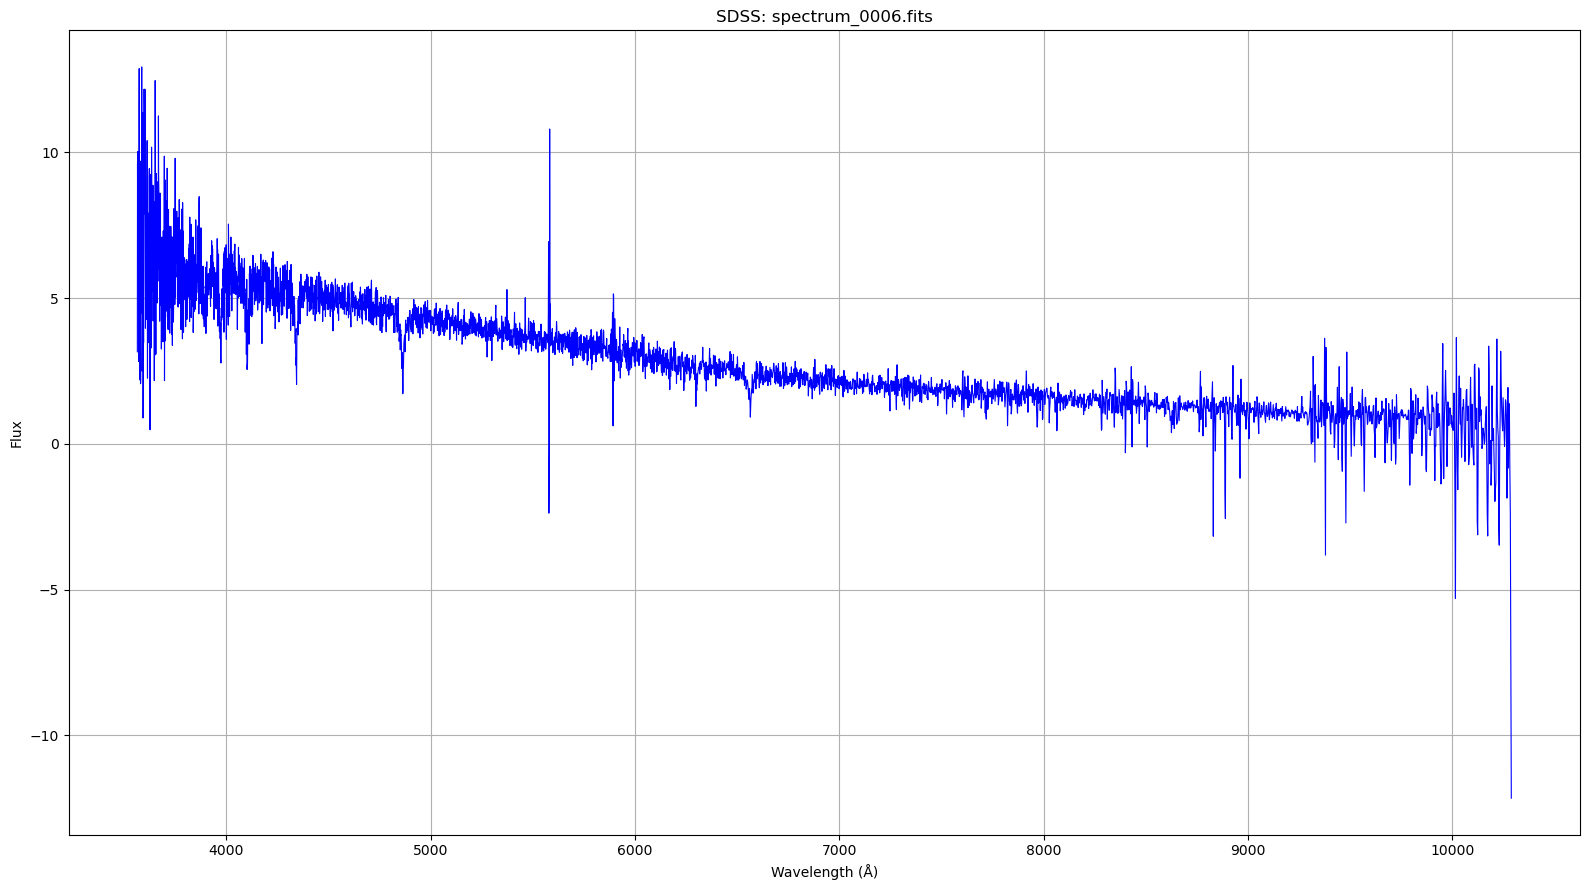

In [563]:
# Graphing the spectrum


file_path = 'sdss_ml_data/spectrum_0006.fits'

# Open FITS file
hdul = fits.open(file_path)
data = hdul[1].data  # Usually the COADD extension
flux = data['flux']
loglam = data['loglam']  # logarithmic wavelength scale
wavelength = 10**loglam  # convert to real wavelength in angstroms

# Plot
plt.figure(figsize=(16, 9))
plt.plot(wavelength, flux, color='blue', lw=0.8)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('SDSS: ' + file_path.split('/')[-1])
plt.grid(True)
plt.tight_layout()
plt.show()

hdul.close()

In [492]:
# Read downloaded data

sdss_matched_gaia= pd.read_csv('/Users/thomasquan/Downloads/Gaia_SDSS_WD_Matched.csv')
sdss_matched_gaia=sdss_matched_gaia.dropna(subset=['Plx'])


In [497]:
sdss_matched_gaia= sdss_matched_gaia[sdss_matched_gaia['Plx'] > 0]
sdss_matched_gaia

,GaiaEDR3,RA_ICRS,DE_ICRS,Plx,Pwd_1,Gmag_1,BPmag,TeffH,loggH,MassH,...,e_zmag,E(B-V),PM,GLON,GLAT,Type,Sp,_RA,_DE,Separation
0,1.869170e+14,46.313330,1.129192,1.2350,0.990392,20.2979,20.2880,NaN,NaN,NaN,...,0.209,0.072,13.9,177.1,-47.2,DB,Sp,46.31325,1.12919,0.287546
1,3.000155e+15,50.512960,4.693618,4.2935,0.988744,20.1912,20.3057,8288.85,8.250069,0.752341,...,0.100,0.113,43.2,177.5,-41.7,DA,Sp,50.51287,4.69372,0.489958
2,3.752805e+15,45.075178,4.783167,2.9608,0.997820,18.7583,18.7686,16114.81,7.790728,0.503018,...,0.058,0.136,5.1,172.1,-45.4,DA,Sp,45.07521,4.78317,0.116374
3,4.081563e+15,48.545479,5.410266,3.4964,0.995843,19.0426,19.1046,15721.07,8.154091,0.706552,...,0.059,0.203,29.7,175.0,-42.6,DZ,Sp,48.54542,5.41022,0.270391
4,7.158989e+15,44.425507,6.335364,12.2341,0.973790,19.4733,20.1327,4720.54,7.797221,0.461846,...,0.047,0.150,160.1,170.0,-44.7,DC,Sp,44.42550,6.33586,1.786040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,6.909606e+18,316.124438,-6.478776,2.8904,0.998562,19.3196,19.2572,17789.85,8.329951,0.821204,...,0.112,0.079,57.8,43.0,-32.4,DB,Sp,316.12450,-6.47856,0.810084
2794,6.909994e+18,313.318165,-7.034951,10.4088,0.991025,18.7901,19.0523,6318.58,8.034958,0.610465,...,0.041,0.072,107.1,40.9,-30.2,DQ,Sp,313.31808,-7.03450,1.652941
2795,6.913395e+18,310.957414,-6.086479,1.2805,0.990357,19.9623,20.0092,15883.08,7.444701,0.393678,...,0.168,0.049,14.7,40.7,-27.7,DB,Sp,310.95742,-6.08650,0.079539
2796,6.914475e+18,310.419800,-4.876451,2.2040,0.999049,19.1910,19.1916,16415.07,7.744856,0.481770,...,0.106,0.042,26.7,41.6,-26.7,DB,Sp,310.41975,-4.87633,0.472194


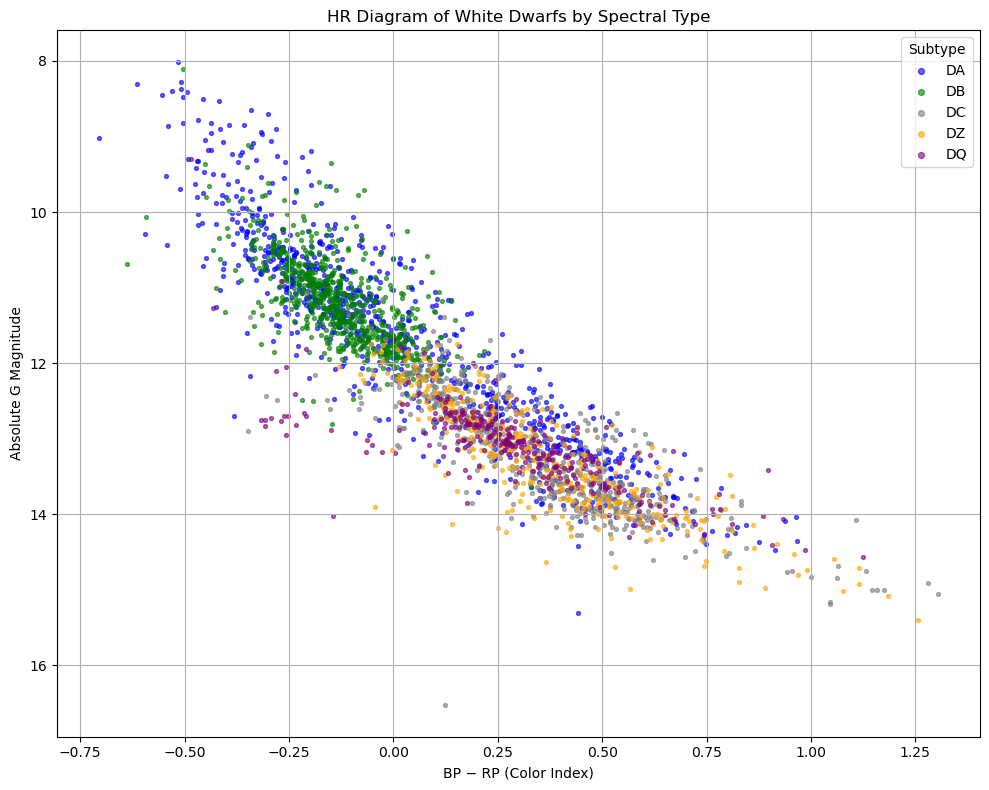

In [501]:
#HR-diagram graphing:

sdss_matched_gaia['distance'] = 1000 / sdss_matched_gaia['Plx'] #Distance

sdss_matched_gaia['absolute_g_mag']=  sdss_matched_gaia['Gmag_1'] - 5 * np.log10(sdss_matched_gaia['distance']) + 5 #Absolute Mag


# Define custom colors for common WD subtypes
subtype_colors = {
    'DA': 'blue',
    'DB': 'green',
    'DC': 'gray',
    'DZ': 'orange',
    'DQ': 'purple',
}

plt.figure(figsize=(10,8))

# Plot each subtype if it exists in your DataFrame
for subtype, color in subtype_colors.items():
    mask = sdss_matched_gaia['Type'] == subtype
    if mask.any():
        plt.scatter(sdss_matched_gaia.loc[mask, 'BP-RP'],
                    sdss_matched_gaia.loc[mask, 'absolute_g_mag'],
                    s=8, c=color, alpha=0.6, label=subtype)

plt.gca().invert_yaxis()
plt.xlabel('BP − RP (Color Index)')
plt.ylabel('Absolute G Magnitude')
plt.title('HR Diagram of White Dwarfs by Spectral Type')
plt.legend(title='Subtype', markerscale=1.5)
plt.grid(True)
plt.tight_layout()
plt.show()



In [575]:
(x_train.values <-10).sum()/x_train.count().sum()

3.0346245303695404e-05

# Pipeline ML

In [533]:
x_train, x_valid,add_data_train,add_data_valid, y_train, y_valid = train_test_split(
    df_spectrum, 
    df_matched[[ 'gmag', 'PM']], 
    df_matched['Type'],
    train_size=0.8, 
    random_state=42
    )

In [542]:
add_data_train = add_data_train.astype('float64')
add_data_valid = add_data_valid.astype('float64')
x_train.columns = x_train.columns.astype(str)
add_data_train.columns = add_data_train.columns.astype(str)
x_valid.columns = x_valid.columns.astype(str)
add_data_valid.columns = add_data_valid.columns.astype(str)


In [397]:
numeric_transformer= Pipeline(steps= [
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    #('pca', PCA(n_components=10))
    ])



In [558]:

def sdss_spec_objective(trial):
    param_sdss= {
    "learning_rate": trial.suggest_float("classifier__learning_rate", 0.01, 0.3, log=True),
    "depth": trial.suggest_int("classifier__depth", 4, 10),
    "l2_leaf_reg": trial.suggest_float("classifier__l2_leaf_reg", 1, 10),
    "iterations": trial.suggest_int("classifier__iterations", 100, 500),
    "random_strength": trial.suggest_float("classifier__random_strength", 0.5, 2.0),
    "bagging_temperature": trial.suggest_float("classifier__bagging_temperature", 0.0, 1.0),
    "rsm": trial.suggest_float("classifier__rsm", 0.5, 1.0),
    }
    model= cb.CatBoostClassifier(**param_sdss, verbose=0,early_stopping_rounds=50)

    
    flux_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=100))
    ])

    # Combine PCA + other features
    full_pipeline = ColumnTransformer([
        ('flux', flux_pipeline, list(x_train.columns)),
        ('meta', 'passthrough', list(add_data_train.columns))
    ])

    pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('classifier', model)
    ])

    # Combine features and labels
    X_full = pd.concat([x_train, add_data_train], axis=1)
    y_full = y_train

    #pipeline_1= Pipeline(steps=[
    #('num_transformer', numeric_transformer),
    #('classifier', model)
    #])
    #scores= cross_val_score(pipeline_1, df_spectrum, df_matched['Type'], cv= 5, scoring= 'accuracy')
    #return 1.0 - scores.mean()


    # 4. Combine PCA fluxes + additional features
    # Ensure all inputs are DataFrames with matching index



    #pipeline_1.fit(pd.concat([x_train_pca,add_data_train],axis=1), y_train)
    #preds= pipeline_1.predict(pd.concat([x_valid_pca,add_data_valid],axis=1))
    #model.fit(x_train_combined, y_train,eval_set=(x_valid_combined, y_valid),
    #early_stopping_rounds=50,
    #verbose=0)
    
    # Stratified KFOLD
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_full, y_full, cv=skf, scoring='f1_macro')

    return scores.mean()
    #preds = model.predict(x_valid_combined)
    #f1 = f1_score(y_valid, preds, average='weighted')
    #return 1.0 - f1
    #accuracy= accuracy_score(y_valid, preds)
    #return 1.0 - accuracy

TypeError: 'numpy.dtypes.ObjectDType' object is not callable

In [559]:
study_spectra= optuna.create_study()
study_spectra.optimize(sdss_spec_objective,n_trials=30,timeout=3600)
print("Best Hyperparameters:", study_spectra.best_params)

[I 2025-07-17 19:48:40,303] A new study created in memory with name: no-name-aa9f9939-e56f-466a-a4cc-8fe1b99ee372


[I 2025-07-17 19:51:49,386] Trial 0 finished with value: 0.777608430928207 and parameters: {'classifier__learning_rate': 0.030819636145307822, 'classifier__depth': 8, 'classifier__l2_leaf_reg': 2.959309807677804, 'classifier__iterations': 430, 'classifier__random_strength': 1.1548943963521257, 'classifier__bagging_temperature': 0.7019891608270704, 'classifier__rsm': 0.5945434470824481}. Best is trial 0 with value: 0.777608430928207.
[I 2025-07-17 19:53:39,080] Trial 1 finished with value: 0.7697439932448432 and parameters: {'classifier__learning_rate': 0.0681721980020871, 'classifier__depth': 8, 'classifier__l2_leaf_reg': 2.534467034450265, 'classifier__iterations': 167, 'classifier__random_strength': 1.101413894107519, 'classifier__bagging_temperature': 0.9161295298592967, 'classifier__rsm': 0.8716647041619336}. Best is trial 1 with value: 0.7697439932448432.
[I 2025-07-17 19:58:37,970] Trial 2 finished with value: 0.796250903869888 and parameters: {'classifier__learning_rate': 0.2424

Best Hyperparameters: {'classifier__learning_rate': 0.010091646790558698, 'classifier__depth': 4, 'classifier__l2_leaf_reg': 4.626361995533947, 'classifier__iterations': 267, 'classifier__random_strength': 1.6654642381660316, 'classifier__bagging_temperature': 0.4352249201982054, 'classifier__rsm': 0.6884406071337844}


In [416]:
print("x_train NaNs:", np.isnan(x_train).sum().sum())
print("add_data_train NaNs:", add_data_train.isna().sum())

x_train NaNs: 1232513
add_data_train NaNs: gmag    0
PM      0
dtype: int64


In [560]:
study_spectra.best_value

0.6660917439294575

In [561]:
best_params = study_spectra.best_params

# 2. Remove the "classifier__" prefix if needed (Optuna might save it like that)
clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}

# 3. Create the final model
best_model = cb.CatBoostClassifier(**clean_params, verbose=0)

flux_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=min(100, x_train.shape[1])))
])

    # Combine PCA + other features
full_pipeline = ColumnTransformer([
    ('flux', flux_pipeline, list(x_train.columns)),
    ('meta', 'passthrough', list(add_data_train.columns))
])

final_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('classifier', best_model)
])

# Combine features and labels
X_full = pd.concat([x_train, add_data_train], axis=1)
y_full = y_train
X_test_full=pd.concat([x_valid, add_data_valid],axis=1)

final_pipeline.fit(X_full, y_full)

preds= final_pipeline.predict(X_test_full)


In [550]:
# Check for Overfitting:
train_preds = final_pipeline.predict(X_full)

# 2. Predict on validation data
valid_preds = final_pipeline.predict(X_test_full)

# 3. Evaluate using the same metric (e.g., accuracy or F1)

train_acc = accuracy_score(y_full, train_preds)
valid_acc = accuracy_score(y_valid, valid_preds)

train_f1 = f1_score(y_full, train_preds, average='macro')
valid_f1 = f1_score(y_valid, valid_preds, average='macro')

print(f"Train Accuracy: {train_acc:.4f}, Valid Accuracy: {valid_acc:.4f}")
print(f"Train F1 Score: {train_f1:.4f}, Valid F1 Score: {valid_f1:.4f}")

Train Accuracy: 0.8551, Valid Accuracy: 0.8056
Train F1 Score: 0.8252, Valid F1 Score: 0.7329


In [562]:
print(best_model.get_best_score())
print(classification_report(y_valid, preds))

{'learn': {'MultiClass': 0.7565359537194845}}
              precision    recall  f1-score   support

          DA       0.93      0.94      0.93       219
          DB       0.85      0.91      0.88       156
          DC       0.56      0.82      0.66       120
          DQ       0.95      0.29      0.44        66
          DZ       0.87      0.63      0.73        82

    accuracy                           0.80       643
   macro avg       0.83      0.72      0.73       643
weighted avg       0.84      0.80      0.79       643



In [538]:
best_params

{'classifier__learning_rate': 0.2144853273276629,
 'classifier__depth': 4,
 'classifier__l2_leaf_reg': 8.595105089488781,
 'classifier__iterations': 536,
 'classifier__random_strength': 1.835200084808174,
 'classifier__bagging_temperature': 0.6785610521697574,
 'classifier__rsm': 0.5956174711546567}

In [472]:
best_params = study.best_params

# 2. Remove the "classifier__" prefix if needed (Optuna might save it like that)
clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}

# 3. Create the final model
best_model = cb.CatBoostClassifier(**clean_params, verbose=0)


imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

x_train_imp = imputer.fit_transform(x_train)
x_valid_imp = imputer.transform(x_valid)

x_train_scaled = scaler.fit_transform(x_train_imp)
x_valid_scaled = scaler.transform(x_valid_imp)
    #pipeline_1= Pipeline(steps=[
    #('num_transformer', numeric_transformer),
    #('classifier', model)
    #])
    #scores= cross_val_score(pipeline_1, df_spectrum, df_matched['Type'], cv= 5, scoring= 'accuracy')
    #return 1.0 - scores.mean()

pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)

    # 4. Combine PCA fluxes + additional features
    # Ensure all inputs are DataFrames with matching index
x_train_combined = pd.concat([
    pd.DataFrame(x_train_pca).reset_index(drop=True),
    add_data_train.reset_index(drop=True)
    ], axis=1)

x_valid_combined = pd.concat([
    pd.DataFrame(x_valid_pca).reset_index(drop=True),
    add_data_valid.reset_index(drop=True)
    ], axis=1)

best_model.fit(x_train_combined, y_train, eval_set=(x_valid_combined, y_valid),
    early_stopping_rounds=50,
    verbose=100)

preds = best_model.predict(x_valid_combined)
    


#final_pipe = Pipeline(steps=[
    #('num_transformer', numeric_transformer),
    #("classifier", best_model)
#])
#final_pipe.fit(x_train, y_train)


0:	learn: 1.3573421	test: 1.3446855	best: 1.3446855 (0)	total: 27.3ms	remaining: 14.6s
100:	learn: 0.3533912	test: 0.4628721	best: 0.4628721 (100)	total: 1.75s	remaining: 7.56s
200:	learn: 0.2408953	test: 0.4227534	best: 0.4227534 (200)	total: 2.87s	remaining: 4.79s
300:	learn: 0.1752244	test: 0.4052036	best: 0.4052036 (300)	total: 3.91s	remaining: 3.05s
400:	learn: 0.1359954	test: 0.3937094	best: 0.3937094 (400)	total: 4.93s	remaining: 1.66s
500:	learn: 0.1114368	test: 0.3855908	best: 0.3854161 (496)	total: 5.93s	remaining: 414ms
535:	learn: 0.1041162	test: 0.3851222	best: 0.3846128 (529)	total: 6.29s	remaining: 0us

bestTest = 0.3846127583
bestIteration = 529

Shrink model to first 530 iterations.


In [473]:
print(best_model.get_best_score())


{'learn': {'MultiClass': 0.10411624634053694}, 'validation': {'MultiClass': 0.38461275832633396}}


In [474]:

print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

          DA       0.97      0.95      0.96       219
          DB       0.93      0.96      0.94       156
          DC       0.68      0.77      0.72       120
          DQ       0.75      0.61      0.67        66
          DZ       0.80      0.77      0.78        82

    accuracy                           0.86       643
   macro avg       0.83      0.81      0.82       643
weighted avg       0.86      0.86      0.86       643

